# Imports

In [1]:
#!pip install tensorflow
#!pip install opencv-python
#!pip install cv2
# !pip install BIRDS
# pip install --upgrade --user pip
# !pip install google.colab
# !pip install itables
# !pip install dill
# !pip install visualkeras
# !pip install pydot

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

# import birds_utils.BIRDS
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random
import pickle
# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
import birds_utils as birds
sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import dill
import copy

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout
from collections import defaultdict

from PIL import ImageFont
import visualkeras


## Import helping functions

In [3]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# # Import series of helper functions for our notebook
# from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
# import urllib.request

# url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
# filename = "helper_functions.py"
# urllib.request.urlretrieve(url, filename)

# Run configuration

In [5]:
# principle parameters
BATCH_SIZE = 32 # size of batch (The ImageDataGenerator objects generate batches of tensor image data with real-time data augmentation)
TARGET_SIZE = (224, 224)    # size of pictures (used by the ImageDataGenerator objects)
N_LABELS = 100    # number of lables for analysis ('all will keep all labels)
N_EPOCHS = 5 # number of epochs for the traning NN
N_SAMPLES_PER_LABEL = 'all' # number of sampels per label that are kept for training ('all' will keep all samples)
N_EPOCHS_PATIENCE = 20
AUGMENTATON = False
BASE_PATH = './models/'
if (AUGMENTATON):
    RUN_NAME = f'birds_augmentation_N_LABELS_{N_LABELS}'
else:
    RUN_NAME = f'birds_no_augmentation_N_LABELS_{N_LABELS}'
label_count_thresh = 50
fig_width = 8

MODEL_PATH = f'{BASE_PATH}{RUN_NAME}/'
if (not os.path.exists(MODEL_PATH)):
    os.makedirs(MODEL_PATH)



# Load and prepare data

## load data

In [6]:
project_dir = '.'
image_df_full = birds.load_data(project_dir).drop_duplicates() 
image_df_full = image_df_full.sample(frac=1, random_state=42)  # frac=1 means the entire DataFrame is sampled



In [7]:
image_df_full.head(5)

Filepath                   label
29615        data\train\CRESTED CARACARA\131.jpg        CRESTED CARACARA
19620        data\train\BORNEAN PHEASANT\065.jpg        BORNEAN PHEASANT
22494           data\train\CAMPO FLICKER\155.jpg           CAMPO FLICKER
3656   data\train\AFRICAN OYSTER CATCHER\084.jpg  AFRICAN OYSTER CATCHER
30859  data\train\CRESTED WOOD PARTRIDGE\110.jpg  CRESTED WOOD PARTRIDGE

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


## EDA

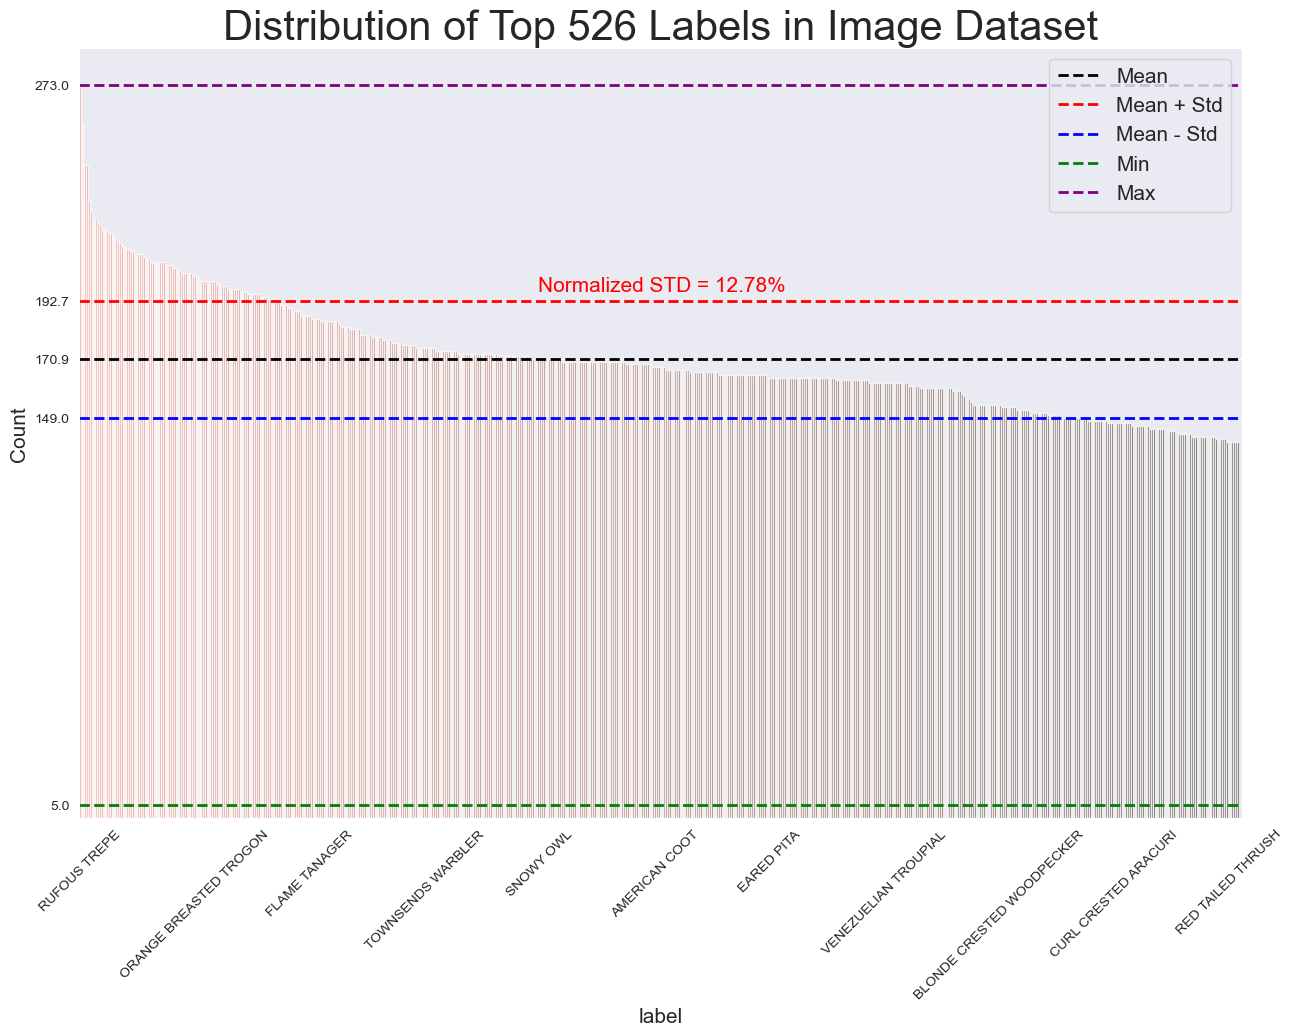

In [9]:
birds.plot_labels_count(image_df_full)

In [10]:
# filter out all the lables with less than label_count_thresh
boolean_vec = image_df_full.groupby('label').count()['Filepath'].values>=label_count_thresh
labels_to_keep = image_df_full.groupby('label').count()[boolean_vec]
image_df = birds.filter_df(image_df_full,labels=list(labels_to_keep.index))

In [11]:
if (N_LABELS=='all'):
    N_LABELS = len(birds.get_labels(image_df))
    
lables = list(birds.get_labels(image_df)[0:N_LABELS])
image_df = birds.filter_df(image_df,labels=lables)
image_df = birds.filter_df(image_df,N_samples_per_label=N_SAMPLES_PER_LABEL)

from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
labels = image_df['label'].tolist() # Make sure this is your training data labels
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))


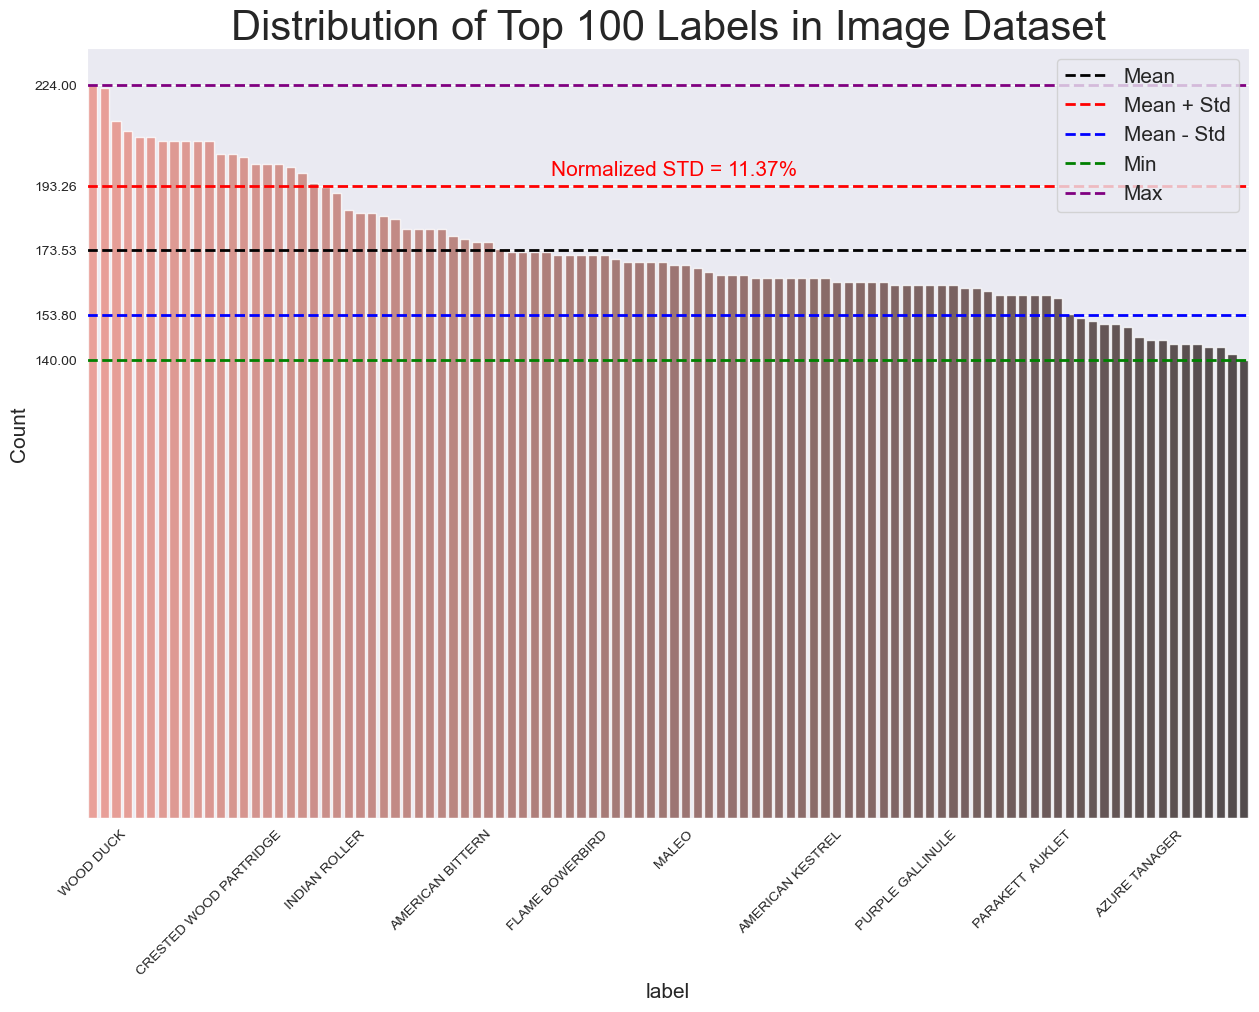

In [12]:
# birds.test_df
# plot all images of a label
# # plot the 1'st 5 instances of a labelbirds.plot_label_images(test_df,label=birds.get_labels(test_df)[1])

# birds.plot_label_images(test_df,label=birds.get_labels(test_df)[1],N=5)

# # plot tests according to idx
# birds.plot_label_tests(test_df,idx=[1,9])

birds.plot_labels_count(image_df)

# Data Splitting into 3 ImageDataGenerators


In [13]:
# Separate in train and test data
train_obj_dic = {'name':'train'}
val_obj_dic = {'name':'val'}
test_obj_dic = {'name':'test'}

# we saw that the df was balanced so we added stratify=image_df['label']

train_df_pre, test_obj_dic['df'] = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42,stratify=image_df['label'])
train_obj_dic['df'], val_obj_dic['df'] = train_test_split(train_df_pre, test_size=0.2, shuffle=True, random_state=42,stratify=train_df_pre['label'])


In [14]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)


test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [15]:

# Split the data into three categories.
train_obj_dic['images_obj'] = train_generator.flow_from_dataframe(
    dataframe=train_obj_dic['df'],
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42,
)

val_obj_dic['images_obj'] = val_generator.flow_from_dataframe(
    dataframe=val_obj_dic['df'],
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42,
)

test_obj_dic['images_obj'] = test_generator.flow_from_dataframe(
    dataframe=test_obj_dic['df'],
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 11105 validated image filenames belonging to 100 classes.
Found 2777 validated image filenames belonging to 100 classes.
Found 3471 validated image filenames belonging to 100 classes.


# Image Augemntation

## Define the image augmentation object

In [16]:
# Data Augmentation Step
RANDOM_FLIP = 'horizontal'
RANDOM_ROTATION = 0.1
RANDOM_ZOOM = 0.9
RANDOM_CONTRAST = 0.1

augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
#   layers.experimental.preprocessing.Rescaling(1./255),
#   layers.experimental.preprocessing.RandomFlip(RANDOM_FLIP),
#   layers.experimental.preprocessing.RandomRotation(RANDOM_ROTATION),
  layers.experimental.preprocessing.RandomZoom(RANDOM_ZOOM),
#   layers.experimental.preprocessing.RandomContrast(RANDOM_CONTRAST),
])

## Observing augemented images

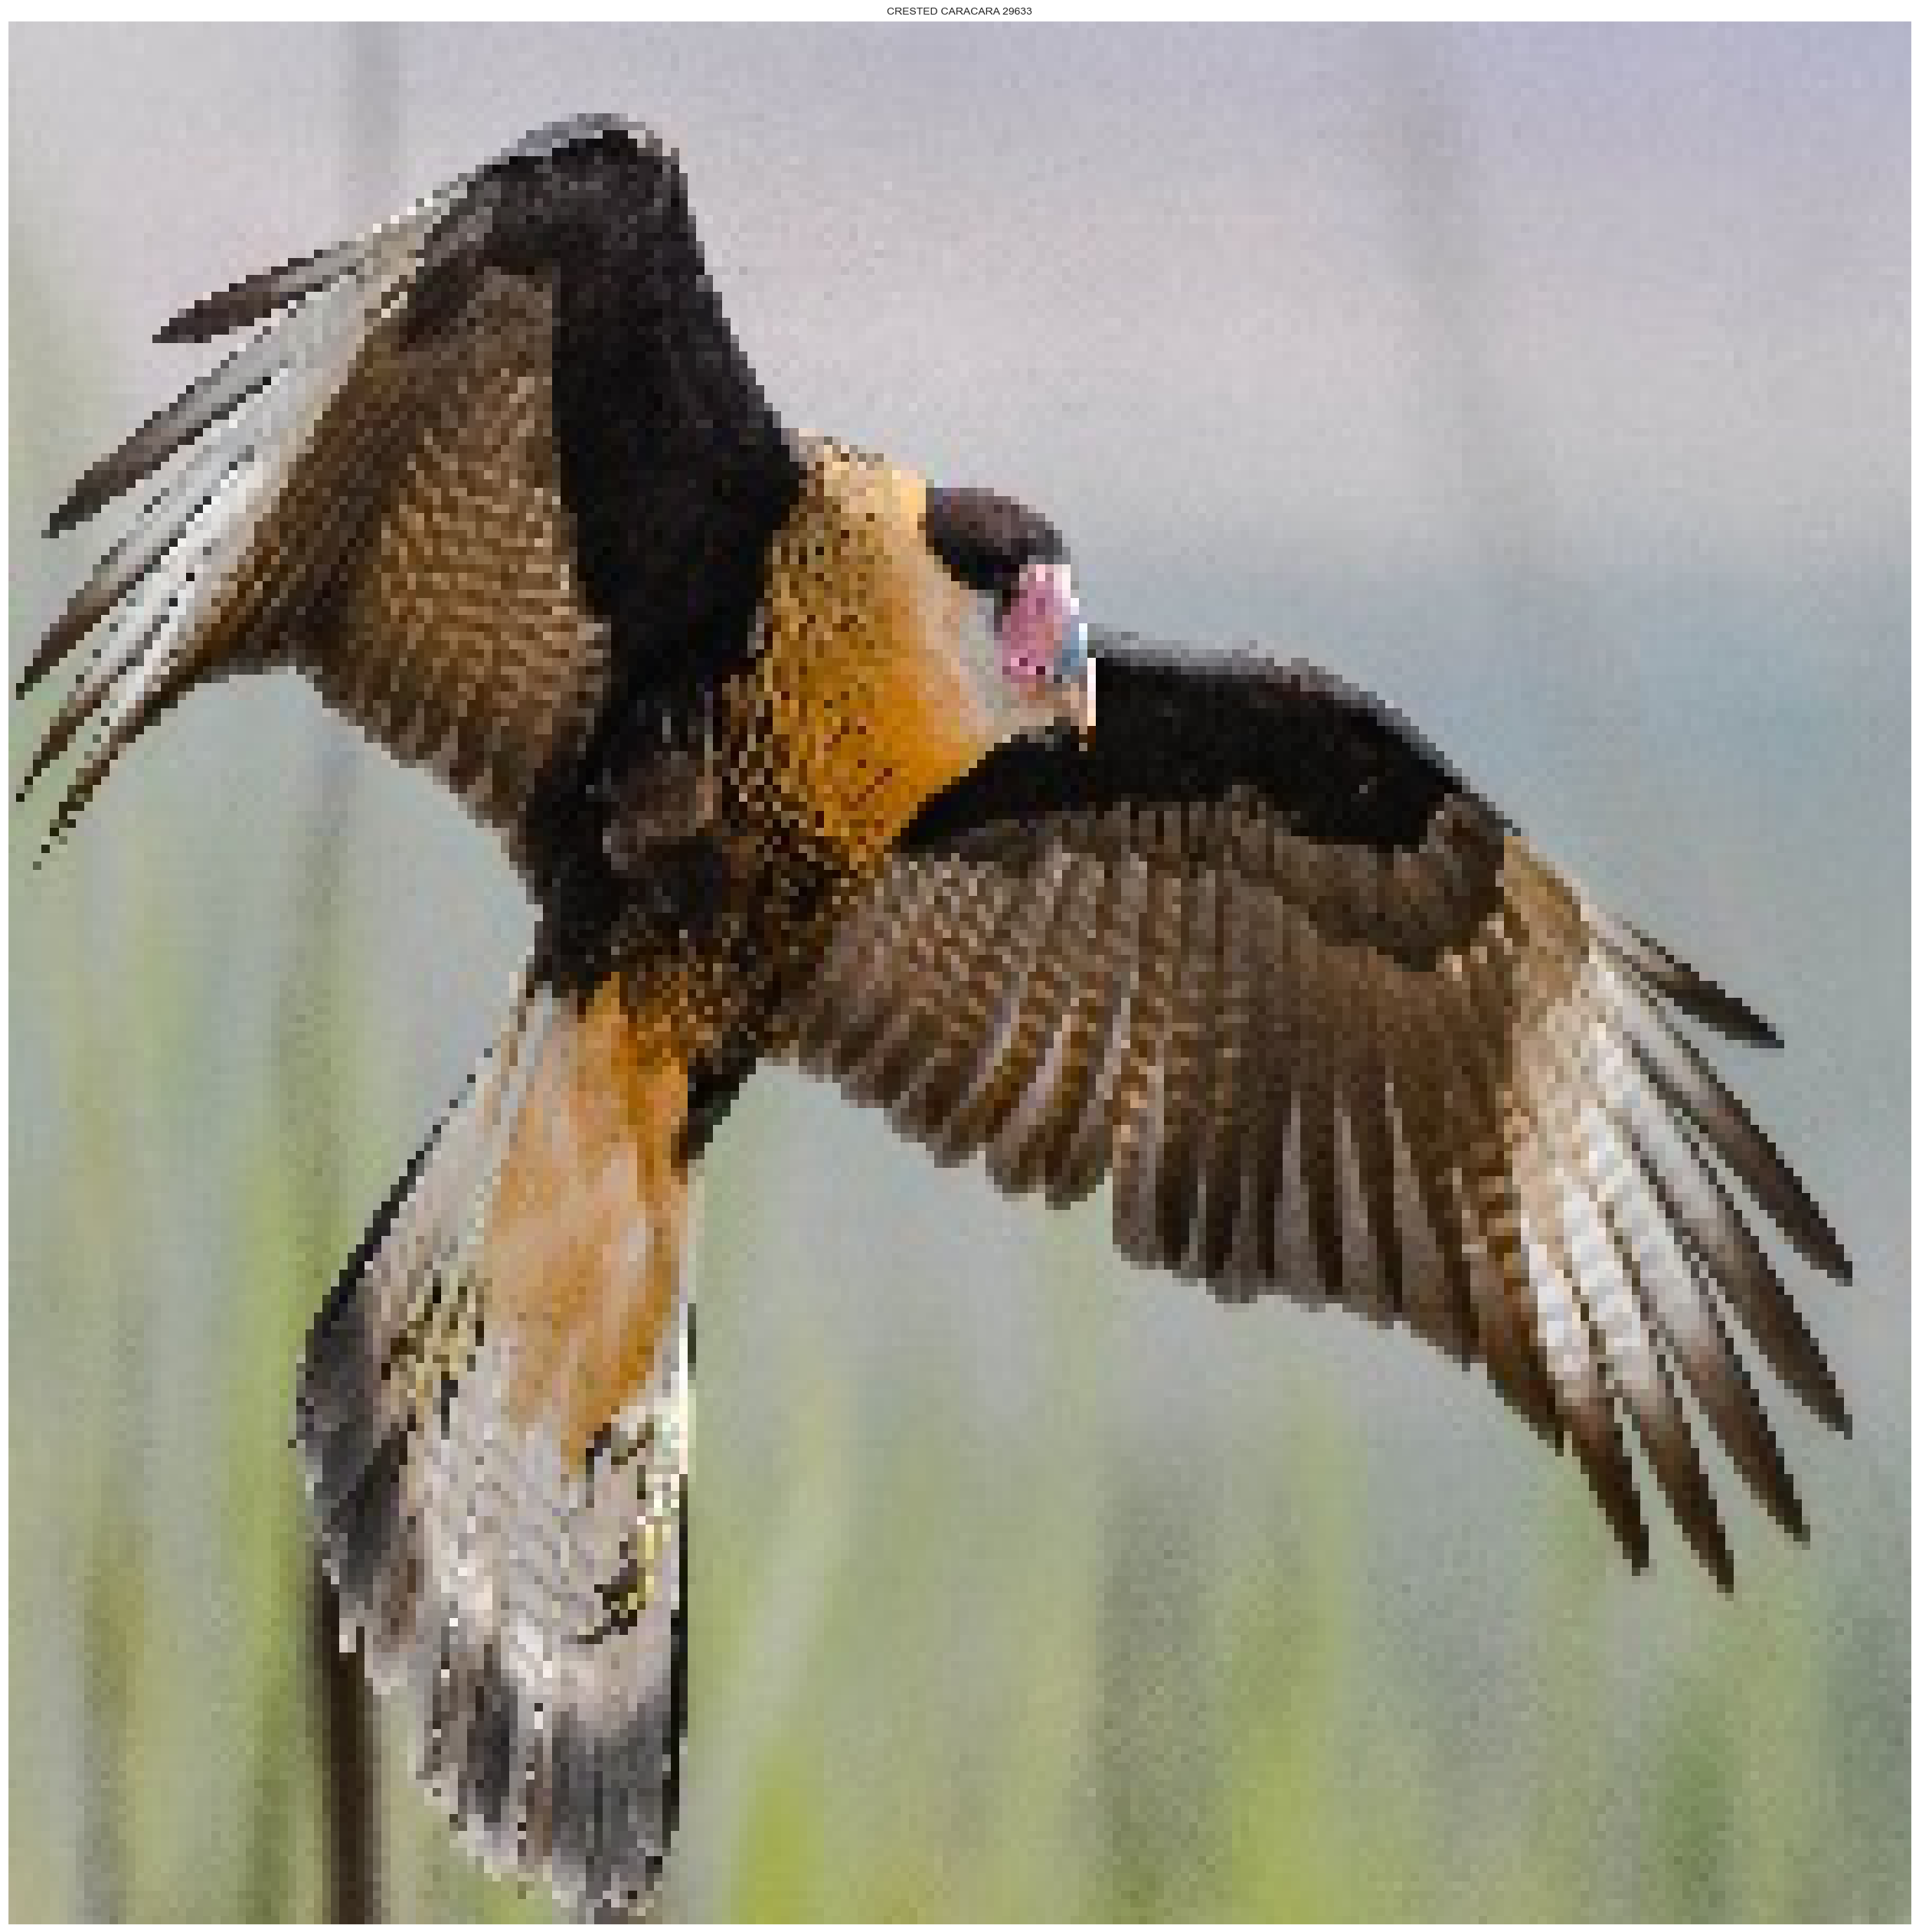

In [17]:
birds.plot_images(image_df,idx=[29633],n_cols=1)


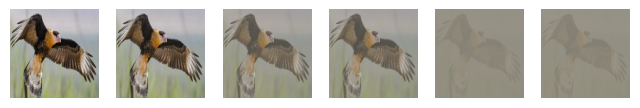

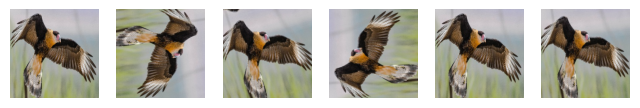

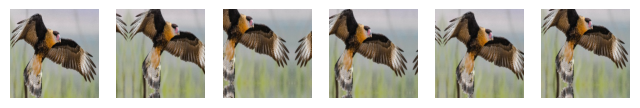

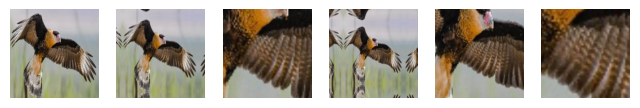

In [18]:
ind = 3
img = birds.get_image(image_df,idx=29633)
import copy


num_cols=6


operation_dic = {
                    'RandomContrast':[1.0,1.0],
                    'RandomRotation':[0,180],
                    'RandomTranslation':[0.1,0.5],  
                    'RandomZoom':[0.9,0.9]                   
                }

num_rows = len(operation_dic.keys())
fig_width = 8


for opration in list(operation_dic.keys()):
    val_vec = np.linspace(operation_dic[opration][0],operation_dic[opration][1],num_cols)
    fig, axes = plt.subplots(1, num_cols, figsize=(fig_width, fig_width*num_rows/num_cols) )
    c=0
    for ind, ax in enumerate(axes.flat):
        img = copy.deepcopy(birds.get_image(image_df[:],idx=29633))
        if (c==0):
            ax.imshow(img)
            ax.axis('off')
            c=1
            continue

        if (opration=='RandomContrast'):
            augment = tf.keras.Sequential([
                layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows])
            ])
        elif (opration=='RandomRotation'):
            augment = tf.keras.Sequential([
                # layers.experimental.preprocessing.RandomRotation([val_vec[ind%num_rows],val_vec[ind%num_rows]])
                layers.experimental.preprocessing.RandomRotation(factor=(0,val_vec[ind%num_rows]))
            ])
            
        elif (opration=='RandomTranslation'):
            augment = tf.keras.Sequential([
                layers.experimental.preprocessing.RandomTranslation(height_factor = val_vec[ind%num_rows],width_factor = val_vec[ind%num_rows])
            ])

        elif (opration=='RandomZoom'):
            augment = tf.keras.Sequential([
                layers.experimental.preprocessing.RandomZoom(val_vec[ind%num_rows])
            ])



        # Example: Replace this line with your image loading logic
        img_array = np.expand_dims(img, axis=0)

        augmented_image = augment(np.expand_dims(img, 0)).numpy().squeeze() / 255

        # Display the augmented image in the current subplot
        ax.imshow(augmented_image)
        ax.axis('off')

        # augment = tf.keras.Sequential([
        #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
        #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
        #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
        #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),
        #         layers.experimental.preprocessing.RandomContrast(val_vec[ind%num_rows]),                
        #     ])


    plt.show()


# Model assembly

In [19]:
color_map = defaultdict(dict)
# customize the colours
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
color_map[layers.Dropout]['fill'] = '#03045e'


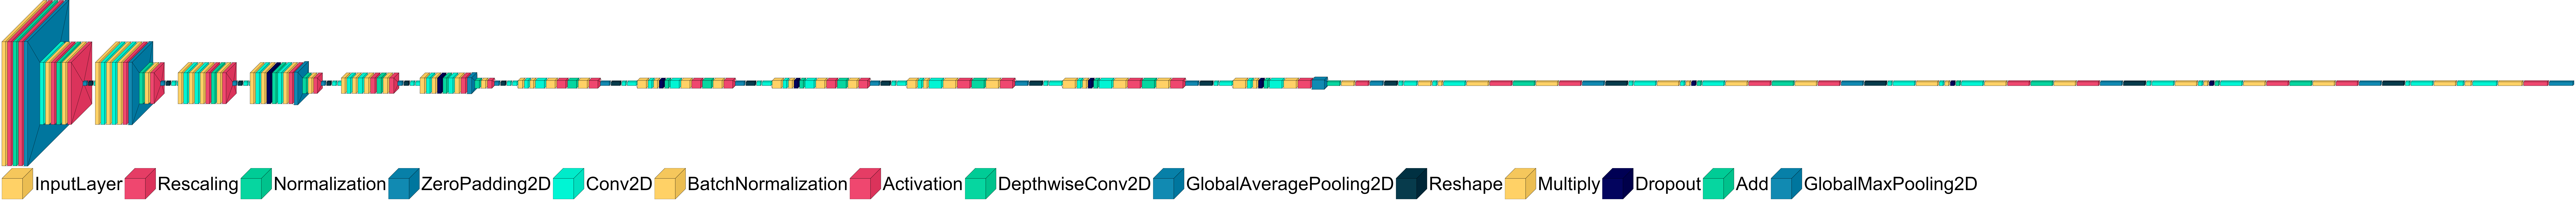

In [20]:
import visualkeras

# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False
font_size = 100
scale_xy=3

# Adjust the font size
font = ImageFont.truetype("arial.ttf", font_size)


visualkeras.layered_view(pretrained_model, legend=True, font=font, to_file='model.png', scale_xy=scale_xy, color_map=color_map)

In [21]:
# Create checkpoint callback
checkpoint_path = f'{MODEL_PATH}/{RUN_NAME}_check_point.h5'
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=False,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = N_EPOCHS_PATIENCE,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

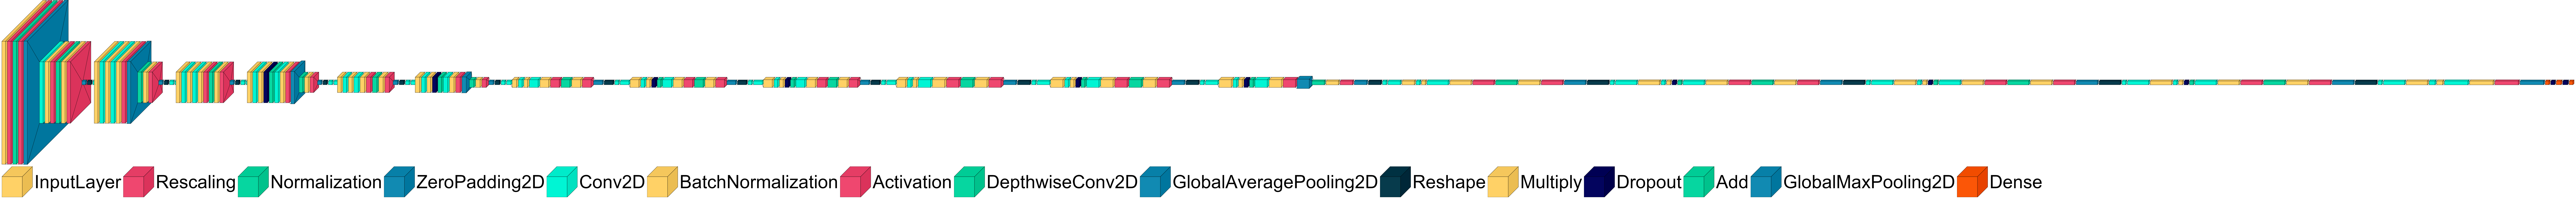

In [22]:
visualize_model = False
AUGMENTATON = False


if (visualize_model):
    input_shape=(224, 224, 3)
    inputs = Input(shape=input_shape)
    font_size = 10
    scale_xy=0.8
else:
    inputs = pretrained_model.input
    inputs.__dict__['_type_spec']
    inputs = pretrained_model.input
    font_size = 100
    scale_xy=3

if (AUGMENTATON):
    x = augment(inputs)
    x = pretrained_model(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.45)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.45)(x)

else:
    if (visualize_model):
        # x = augment(inputs)
        # x = Dense(128, activation='relu')(pretrained_model.output)
        x = inputs
        x = pretrained_model(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.45)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.45)(x)
    else:
        inputs = pretrained_model.input
        # x = augment(inputs)
        x = Dense(128, activation='relu')(pretrained_model.output)
        x = Dropout(0.45)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.45)(x)
    


outputs = Dense(N_LABELS, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



# Adjust the font size
font = ImageFont.truetype("arial.ttf", font_size)



# Save the model image to a file with specific colors for each layer
visualkeras.layered_view(model, legend=True, font=font, to_file='model.png', scale_xy=scale_xy, color_map=color_map)
# keras.utils.plot_model(model, show_shapes=True)





# Model training 

In [23]:
model_file_path = f'{MODEL_PATH}/{RUN_NAME}.keras'
history_file_path = f'{MODEL_PATH}/{RUN_NAME}.pkl'

if os.path.exists(model_file_path):
# load model    
    print(f'loading {RUN_NAME} and related history')
    model = keras.models.load_model(model_file_path)
    # Later, you can load the history object
# load history   
    with open(history_file_path, 'rb') as file:
        history = pickle.load(file)
        history = pd.DataFrame({'history':history})

else:
    if os.path.exists(checkpoint_path):
        print (f'loading check point from {checkpoint_path}')
        model = keras.models.load_model(checkpoint_path)
    
    history = model.fit(
        train_obj_dic['images_obj'],
        steps_per_epoch=len(train_obj_dic['images_obj']),
        validation_data=val_obj_dic['images_obj'],
        validation_steps=len(val_obj_dic['images_obj']),
        epochs=N_EPOCHS,
        class_weight=class_weights_dict,
        callbacks=[
            early_stopping,
            # birds.create_tensorboard_callback("training_logs",
            #                             "bird_classification"),
            checkpoint_callback,
            reduce_lr
        ]
    )

    model.save(model_file_path)
    with open(history_file_path, 'wb') as file:
        pickle.dump(history.history, file)



loading birds_no_augmentation_N_LABELS_100 and related history


# Model Evaluation

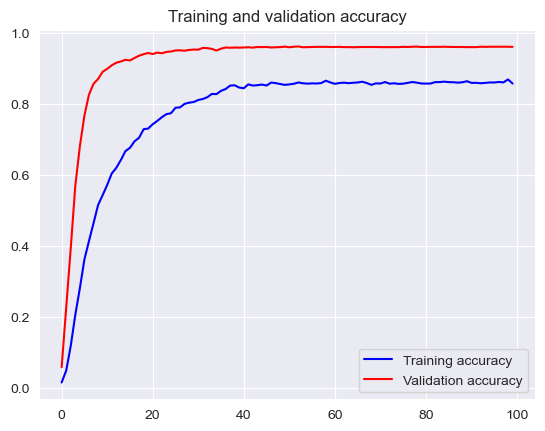

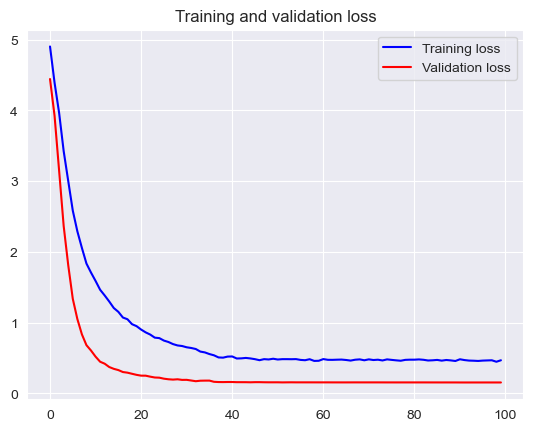

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [62]:
import pandas as pd
from sklearn.metrics import accuracy_score

def calculate_accuracy_per_label(df, label_col='label', predicted_col='predicted_label'):
    """
    Calculate accuracy for each unique label in a DataFrame.

    Parameters:
    - df: DataFrame
        The DataFrame containing 'label' and 'predicted_label' columns.
    - label_col: str, default='label'
        The column name for the true labels.
    - predicted_col: str, default='predicted_label'
        The column name for the predicted labels.

    Returns:
    - accuracy_per_label: dict
        A dictionary containing accuracy for each unique label.
    """
    accuracy_per_label = {}

    # Get unique labels
    labels = df[label_col].unique()

    for label in labels:
        mask = df[label_col] == label
        accuracy = accuracy_score(df.loc[mask, label_col], df.loc[mask, predicted_col])
        accuracy_per_label[label] = accuracy

    accuracy_df = pd.DataFrame(list(accuracy_per_label.items()), columns=['label', 'accuracy'])
    accuracy_df.set_index('label', inplace=True)

    return accuracy_df

# accuracy_per_label = calculate_accuracy_per_label(obj_dic_stack['train']['df'])



In [39]:
def apply_model(model,labels_dic,obj_dic,plot_report=True):
# apply the model    
    pred = model.predict(obj_dic['images_obj'])
    results = model.evaluate(obj_dic['images_obj'], verbose=0)

    pred = np.argmax(pred,axis=1)
    pred = [labels_dic[k] for k in pred]
    
    obj_dic['df']['predicted_label'] = pred
    obj_dic['df']['status'] = obj_dic['df']['predicted_label']==obj_dic['df']['label']

    print ('\n')    
    print ('--------------------------------')
    print (f"    results for {obj_dic['name']}")
    print ('--------------------------------')
    print(f"{obj_dic['name']} Loss: {results[0]:.5f}")
    print(f"{obj_dic['name']} Accuracy: {(results[1] * 100):.2f}%")

    # print(f"{obj_dic['name']}:")
    obj_dic['classification_report'] = get_classification_report(obj_dic['df']['label'], obj_dic['df']['predicted_label'])

    # add accuracy
    accuracy_df = calculate_accuracy_per_label(obj_dic['df'], label_col='label', predicted_col='predicted_label')

    obj_dic['classification_report'] = obj_dic['classification_report'].merge(accuracy_df, left_index=True, right_index=True)


    # plot if desired
    if (plot_report):
        plot_columns = list(obj_dic['classification_report'].columns)
        plot_columns.remove('support')
        name = obj_dic['name']
        obj_dic['classification_report'][plot_columns].plot(rot=45,title=f'{name}:classification report')


    print(obj_dic['classification_report'] )

    return obj_dic



In [65]:
def get_obj_dic_stack(model,train_obj_dic,val_obj_dic,test_obj_dic,obj_dic_stack_path):
    if os.path.exists(obj_dic_stack_path):
        print(f'loding obj_dic_stack from {obj_dic_stack_path}')
        with open(obj_dic_stack_path, 'rb') as file:
            obj_dic_stack = pickle.load(file)
    else:
        labels_dic = create_lables_dic(train_obj_dic['images_obj'])
        test_obj_dic = apply_model(model,labels_dic,test_obj_dic)
        train_obj_dic = apply_model(model,labels_dic,train_obj_dic)
        val_obj_dic = apply_model(model,labels_dic,val_obj_dic)


        # def analyze_classifaction_reports(train_obj_dic,val_obj_dic,test_obj_dic):
        obj_dic_stack = {'train':train_obj_dic,'val':val_obj_dic,'test':test_obj_dic}

        save_obj_dic_stack (obj_dic_stack,obj_dic_stack_path)
# add accuracy
    for key in obj_dic_stack.keys():
        if 'accuracy' not in obj_dic_stack[key]['df']:
            accuracy_df = calculate_accuracy_per_label(obj_dic_stack[key]['df'], label_col='label', predicted_col='predicted_label')
            obj_dic_stack[key]['classification_report'] = obj_dic_stack[key]['classification_report'].merge(accuracy_df, left_index=True, right_index=True)

    return obj_dic_stack
    
obj_dic_stack_path = f'{MODEL_PATH}{RUN_NAME}_obj_dic_stack.pkl'
obj_dic_stack = get_obj_dic_stack(model,train_obj_dic,val_obj_dic,test_obj_dic,obj_dic_stack_path)




loding obj_dic_stack from ./models/birds_no_augmentation_N_LABELS_100/birds_no_augmentation_N_LABELS_100_obj_dic_stack.pkl


In [64]:
obj_dic_stack['test']['classification_report']

precision    recall  f1-score  support  accuracy
AFRICAN OYSTER CATCHER   1.000000  1.000000  1.000000     33.0  1.000000
PHILIPPINE EAGLE         1.000000  1.000000  1.000000     33.0  1.000000
RAINBOW LORIKEET         1.000000  1.000000  1.000000     30.0  1.000000
COMMON LOON              1.000000  1.000000  1.000000     34.0  1.000000
CRESTED AUKLET           1.000000  1.000000  1.000000     34.0  1.000000
...                           ...       ...       ...      ...       ...
ABBOTTS BABBLER          0.789474  0.857143  0.821918     35.0  0.857143
AZARAS SPINETAIL         0.775000  0.861111  0.815789     36.0  0.861111
FASCIATED WREN           0.857143  0.750000  0.800000     32.0  0.750000
AUSTRAL CANASTERO        0.725000  0.878788  0.794521     33.0  0.878788
GREAT XENOPS             0.774194  0.750000  0.761905     32.0  0.750000

[100 rows x 5 columns]

loding obj_dic_stack from ./models/birds_no_augmentation_N_LABELS_100/birds_no_augmentation_N_LABELS_100_obj_dic_stack.pkl


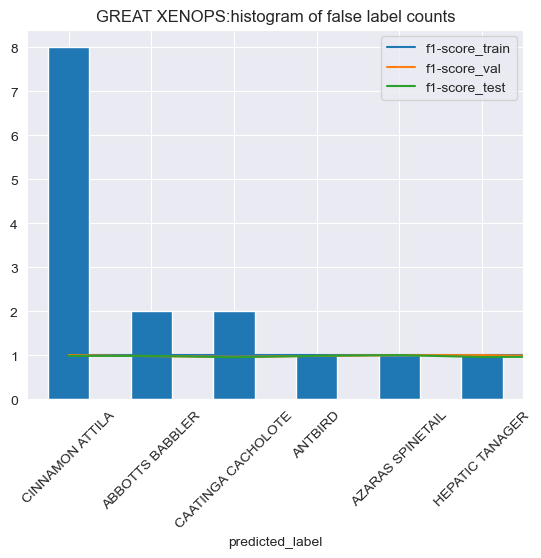

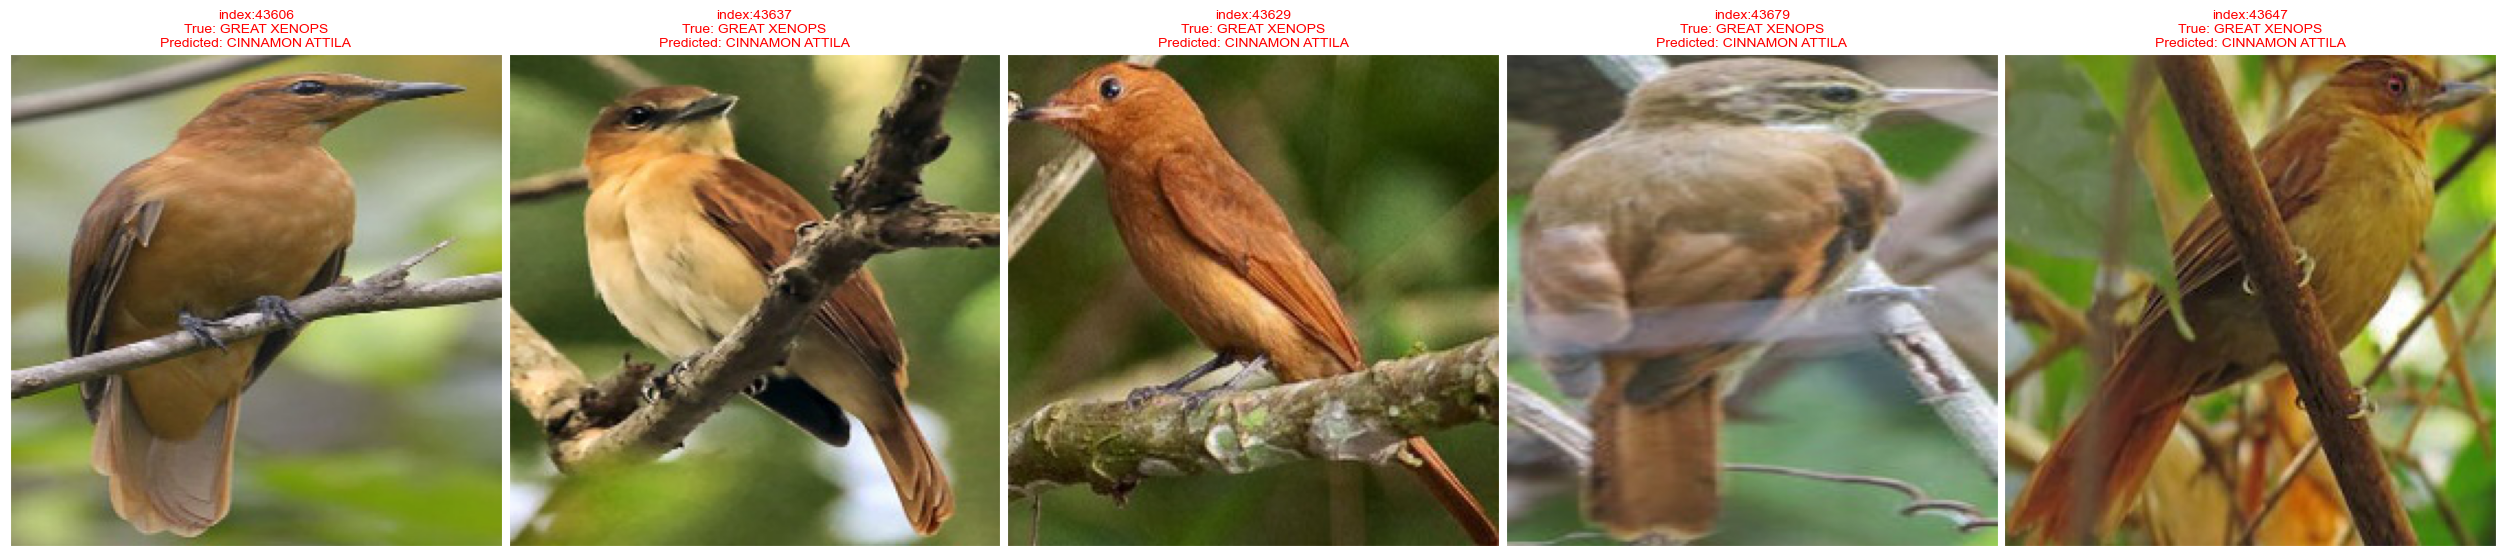

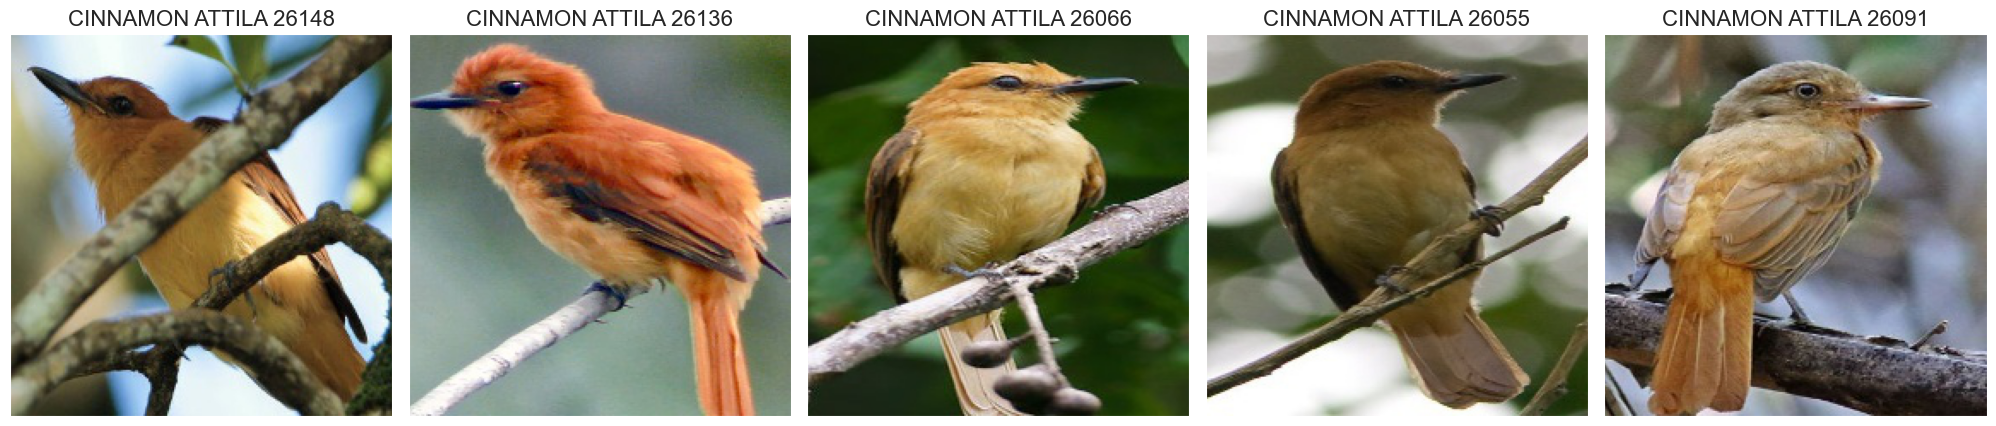

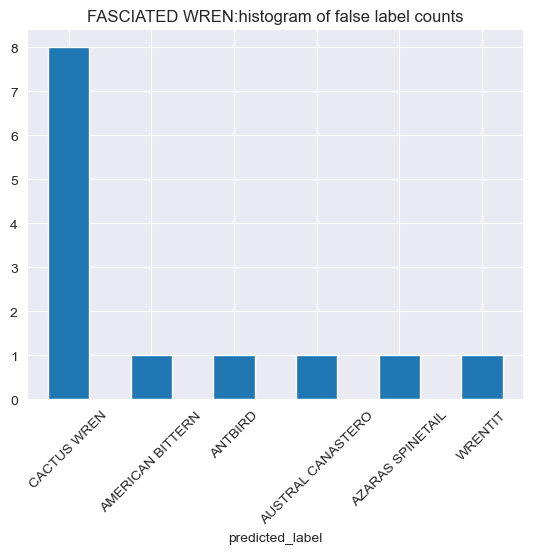

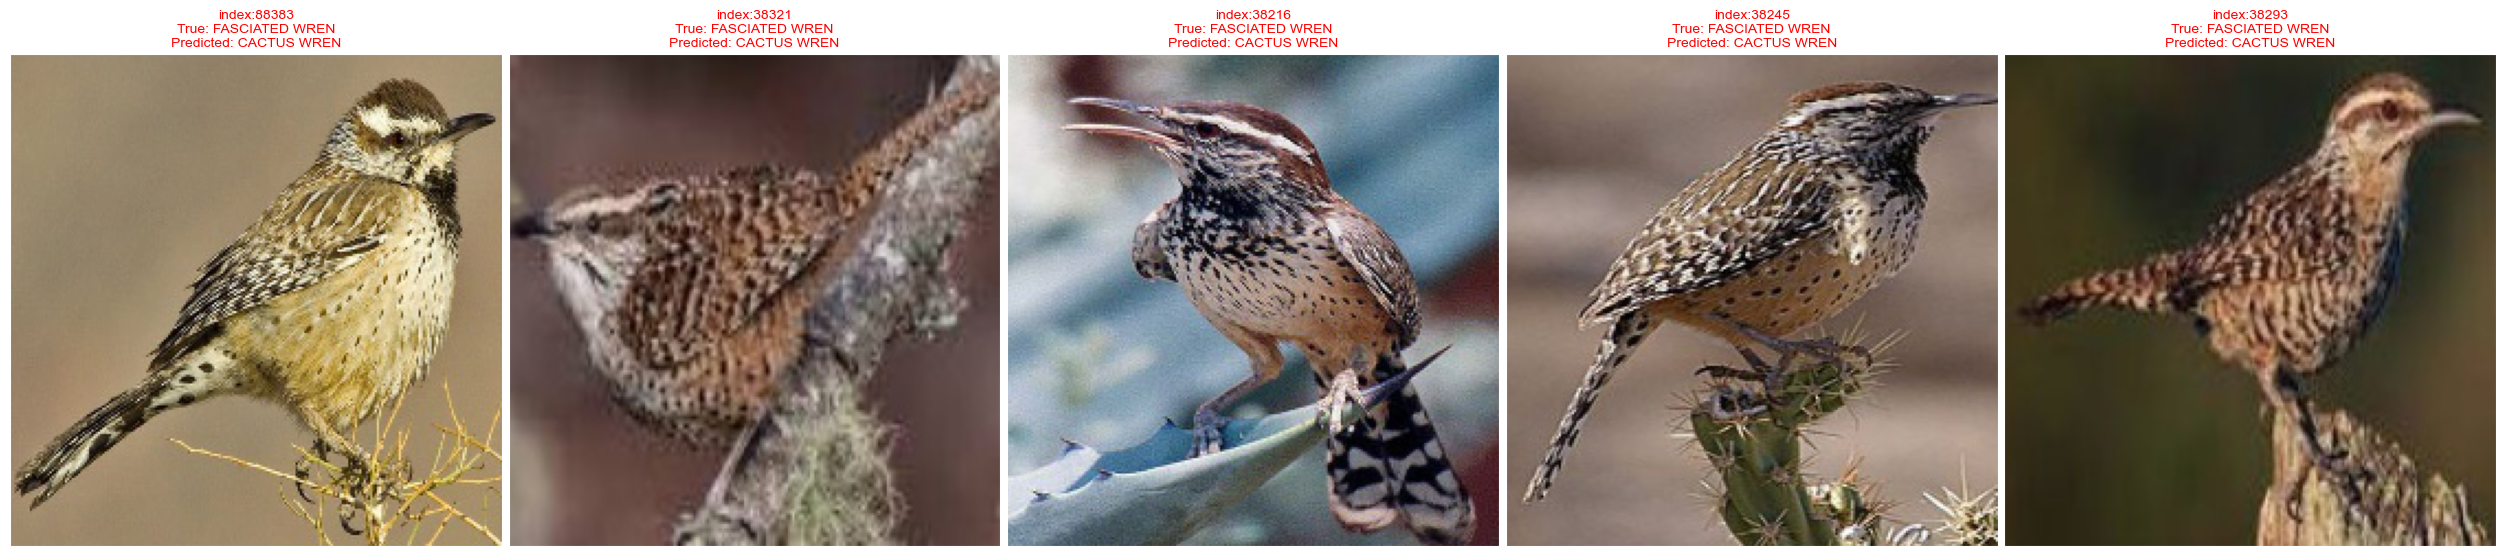

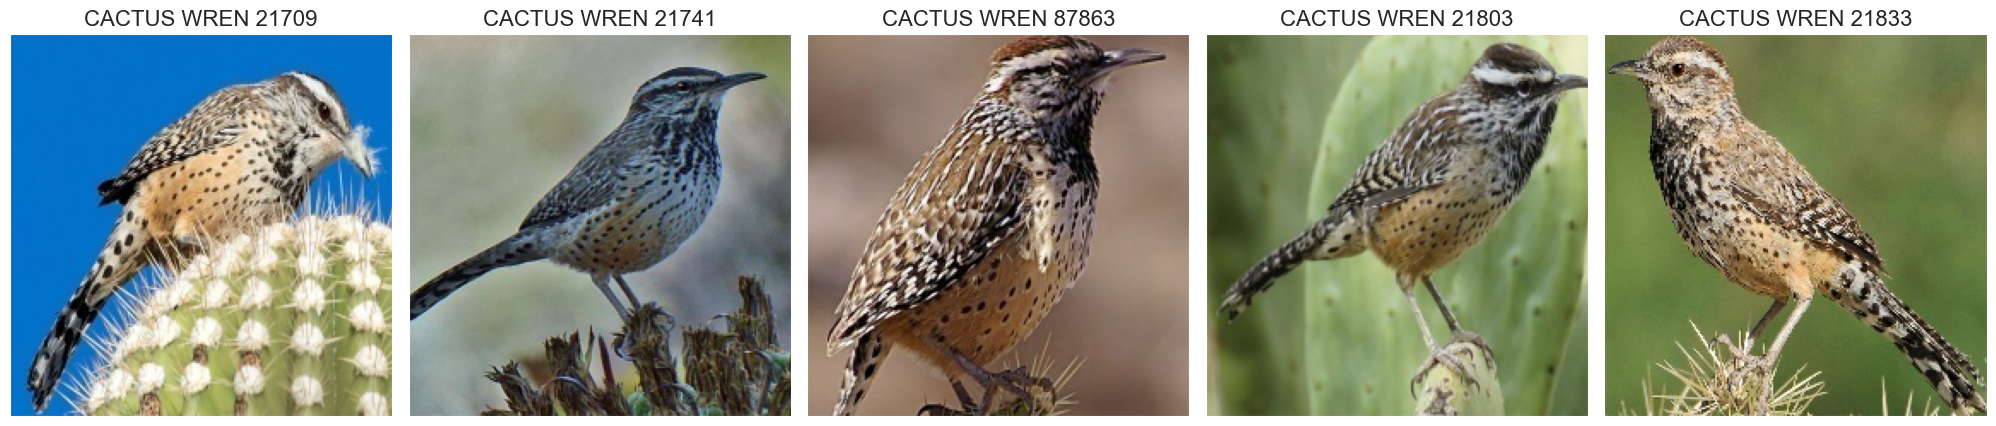

In [25]:
# creat (or load) the obj_dic_stack including all data for model performance analysis
obj_dic_stack_path = f'{MODEL_PATH}{RUN_NAME}_obj_dic_stack.pkl'
obj_dic_stack = birds.get_obj_dic_stack(model,train_obj_dic,val_obj_dic,test_obj_dic,obj_dic_stack_path)

# plot score peformance for all 3 datasets
birds.plot_obj_dic_stack_score(obj_dic_stack)
birds.plot_label_false_and_true(obj_dic_stack,ana_label=None,ana_label_ind=0,n_cols=5,N=5,false_ind=0,false_label = None)
birds.plot_label_false_and_true(obj_dic_stack,ana_label=None,ana_label_ind=1,n_cols=5,N=5,false_ind=0,false_label = None)

In [26]:
df = obj_dic_stack['train']['classification_report'].sort_values('f1-score')
df.head()



precision    recall  f1-score  support
GREAT XENOPS       0.925532  0.852941  0.887755    102.0
FASCIATED WREN     0.967391  0.872549  0.917526    102.0
AZARAS SPINETAIL   0.936937  0.912281  0.924444    114.0
CINNAMON ATTILA    0.879032  0.990909  0.931624    110.0
HEPATIC TANAGER    0.970297  0.899083  0.933333    109.0

# ☀️Grad-Cam Visualization

<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Grad-CAM (Gradient-weighted Class Activation Mapping)</b> is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction. It allows you to see which regions of the image the model focused on while making its prediction. Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.</p>
</div>

In [27]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [28]:
# # Display the part of the pictures used by the neural network to classify the pictures
# obj_dic = test_obj_dic
# fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})
# random_index = np.random.randint(0, len(obj_dic['df']) - 1, 15)

# for i, ax in enumerate(axes.flat):
#     img_path = obj_dic['df'].Filepath.iloc[random_index[i]]
#     img_array = preprocess_input(get_img_array(img_path, size=img_size))
#     heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
#     cam_path = save_and_display_gradcam(img_path, heatmap)
#     ax.imshow(plt.imread(cam_path))
#     ax.set_title(f"True: {obj_dic['df'].label.iloc[random_index[i]]}\nPredicted: {obj_dic['df'].predicted_label.iloc[random_index[i]]}")
# plt.tight_layout()
# plt.show()

***

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            Thanks for viewing my work. If you like it, consider sharing it to others or give feedback to improve the notebook. Have a beautiful day my friend.
        </p>
    </div>

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s'
     height=30px width=160px /></center>